# Chapter 6: The Coalescent - Complementary msprime demo

## Simulating the coalescent

### Coalescent genealogies

Corresponding subchapter outlines the methodology for generating simple coalescent genealogies. We will replicate examples from this chapter using coalescent simulator msprime.

"msprime is an reimplementation of Hudson's ms program for simulating genomic datasets under the coalescent model with recombination. msprime is capable of simulating sample sizes far larger than any other simulators, and is generally extremely efficient. Because it simulates datasets with the tree sequence structure, extracting statistics from the simulations is generally also extremely quick. We will see that it can easily simulate chromosome-sized regions for hundreds of thousands of samples, allowing us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance on a scale that was previously impossible."

Starting from loading required python libraries:

In [48]:
import msprime
import numpy as np
import scipy
from IPython.display import SVG
import tskit
#import allel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io

import matplotlib as ml
%matplotlib inline
font = {'family' : 'Sans', 'weight' : 'normal','size': 16}
ml.rc('font', **font)
#ml.rcParams['figure.figsize'] = (5.0, 5.0)
ml.rcParams['text.usetex'] =False
ml.rc('font', family='serif',size=12)

We will first simulate genealogy of 5 chromosomes (samples in msprime terminology) to replicate Figure 6.2.
We only need to specify one parameter - n

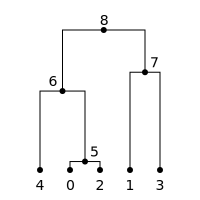

In [4]:
ts = msprime.simulate(sample_size = 5, random_seed = 1)
tree = ts.first()
SVG(tree.draw())

msprime stores genealogy information in a table format called TreeSequence, further we will take a closer look at it's structure.

We can now run the simulation above multiple times to ensure, that each simulation will produce different genealogy (Figure 6.3) 

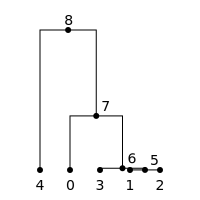

In [13]:
ts = msprime.simulate(sample_size = 5)
tree = ts.first()
SVG(tree.draw())

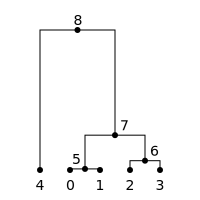

In [14]:
ts = msprime.simulate(sample_size = 5)
tree = ts.first()
SVG(tree.draw())

To simulate genetic variation, we'll need to add some mutations to our tree sequences. Mutations are generated in msprime by sprinkling mutations over the branches of trees at a rate specified by the mutation_rate input to simulate. msprime supports simulating mutations under the infinitely many sites model. 

Note: we provide the scaled mutation rate θ

We will now replicate Figure 6.4 by introducing new parameter: mutation_rate

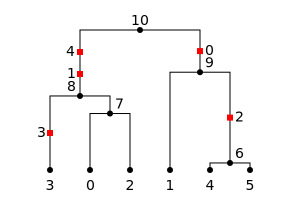

In [34]:
ts = msprime.simulate(sample_size = 6, random_seed = 2, mutation_rate = 1)

for tree in ts.trees():
    #print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))    

In [33]:
print('Site ID\t', 'Site position\t\t', 'Alleles\t', 'Genotypes\t')
for var in ts.variants():
    print(var.site.id, var.site.position, var.alleles, var.genotypes, sep="\t")

Site ID	 Site position		 Alleles	 Genotypes	
0	0.07964547094888985	('0', '1')	[0 1 0 0 1 1]
1	0.4942368404008448	('0', '1')	[1 0 1 1 0 0]
2	0.5867969789542258	('0', '1')	[0 0 0 0 1 1]
3	0.8182267220690846	('0', '1')	[0 0 0 1 0 0]
4	0.8539752908982337	('0', '1')	[1 0 1 1 0 0]


## Understanding the coalescent

Here we will replicate some of the theoretical predictions from the coalescent theory. Simulations modified from Kelleher & Lohse tutorial. 

### Total tree length

Expected total tree length of coalescent tree mathematically described in equation 6.4. 
We can check, if our simulations meet theoretical expectation. In order to do that, we need to repeat our simulation multiple times (parameter num_replicates). Additionally, we can test how length of the genealogy depends on number individuals involved (variable ns).

(Besides msprime, numpy, pandas and seaborn libraries are used here. Feel free to ignore it, if it's not helpful:)

In [26]:
#simulating data
ns = np.array([5, 20, 50, 100]) #setting different sample sizes
num_reps = 10000 #number of replicates
n_col = np.zeros(ns.shape[0] * num_reps)
T_total_col = np.zeros(ns.shape[0] * num_reps)
row = 0
for n in ns:
    for ts in msprime.simulate(n, Ne=0.5, num_replicates=num_reps):
        tree = ts.first()
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})

Let's plot distribution of coalescent times for some arbitrary sample size

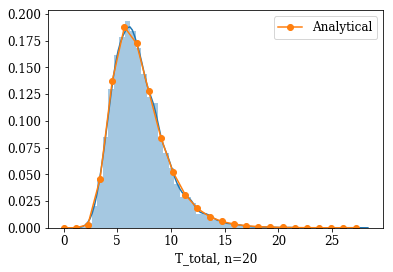

In [27]:
n = 20
T_total_20 = T_total_col[n_col == n]
ts = np.linspace(0, np.max(T_total_20), 25)
t_densities = np.array([T_total_density(n, t) for t in ts])
sns.distplot(T_total_20)
plt.plot(ts, t_densities, marker="o", label="Analytical")
plt.xlabel("T_total, n=20")
plt.legend();

We can now explore, how this distribution looks for different sample sizes. Let's try to simulate Leptidea sample set used for recombination experiment by providing equivalent sample size.

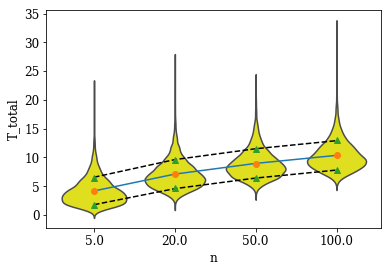

In [28]:
def T_total_mean(n):
    return 2 * np.sum(1 / np.arange(1, n))

def T_total_var(n):
    return 4 * np.sum(1 / np.arange(1, n)**2)

mean_T = np.array([T_total_mean(n) for n in ns])
stddev_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="yellow", inner=None)
ax.plot(mean_T, "-");
ax.plot(mean_T - stddev_T, "--", color="black");
ax.plot(mean_T + stddev_T, "--", color="black");
group = df.groupby("n")
mean_sim = group.mean()
stddev_sim = np.sqrt(group.var())
x = np.arange(ns.shape[0])
ax.plot(x, mean_sim, "o")
line, = ax.plot(x, mean_sim - stddev_sim, "^")
ax.plot(x, mean_sim + stddev_sim, "^", color=line.get_color());
plt.show()

Since we cannot directly observe branch lengths, we are usually more interested in mutations when working with data. The mutation process is intimately related to the distribution of branch lengths, since mutations occur randomly along tree branches. One simple summary of the mutational process is the total number of segregating sites, that is, the number of sites at which we observe variation (see Equations 6.5-6.11). We can obtain this very easily from simulations simply by specifying a mutation rate parameter. (Note again that we set Ne = 1∕2 and our mutation rate = θ∕2 in order to convert to msprime’s time scales.)

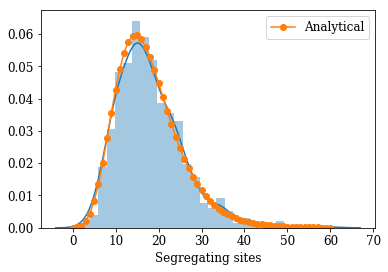

In [30]:
def S_dist(n, theta, k):
    S = 0
    for i in range(2, n + 1):
        S += ((-1)**i * scipy.special.binom(n - 1, i - 1) 
              * (i - 1) / (theta + i - 1) * (theta / (theta + i - 1))**k)
    return S

n = 20
theta = 5
num_replicates = 1000
simulation = np.zeros(num_replicates)
replicates = msprime.simulate(
    n, Ne=0.5, mutation_rate=theta / 2, num_replicates=num_replicates)
for j, ts in enumerate(replicates):
    simulation[j] = ts.num_sites  # number of seg. sites
ks = np.arange(np.max(simulation))
analytical = np.array([S_dist(n, theta, k) for k in ks])
sns.distplot(simulation) 
plt.plot(ks, analytical, marker='o', label="Analytical")
plt.xlabel("Segregating sites")
plt.legend();

### Coalescent with recombination

The key feature of msprime is efficient simulation of coalescent with recombination, which takes advantage of novel data format - TreeSequence. We introduce it here before moving on to simulating recombination.

#### The key idea
Common haplotypes in a sample are often simply a consequence of some common history. So if we know this history (as we always do in simulations!), storing it directly is often more convenient and efficient than storing the raw haplotypes.
A tree sequence is an encoding of a complete genealogy for a sample of chromosomes at each chromosomal location. Key features of tree sequence:
- Stores large simulated datasets extremely compactly. (Often >100 of times smaller than VCFs format)
- Hold rich detail about the history of the sample,  tree sequence is often more informative than raw genotype/haplotype data.
- Can be modified extremely quickly and enable quick calculation of major population statistics.

https://github.com/DRL/SMBE-SGE-2019/blob/master/Session_1/pics/tree-sequence.png

Let's get back to our first simple example to see how results of the simulation are stored

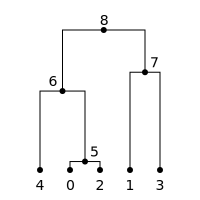

In [37]:
ts = msprime.simulate(sample_size = 5, random_seed = 1)
tree = ts.first()
SVG(tree.draw())

#ts.num_nodes
#ts.num_edges

Now we use function "tables" to display the results:

In [38]:
tables = ts.tables
print(tables)

############################################################
#   Individuals                                            #
############################################################
id	flags	location	metadata
############################################################
#   Nodes                                                  #
############################################################
id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	0	0	-1	0.10792116530237	
6	0	0	-1	1.00674711128465	
7	0	0	-1	1.24675560985525	
8	0	0	-1	1.78536352520779	
############################################################
#   Edges                                                  #
############################################################
id	left		right		parent	child
0	0.00000000	1.00000000	5	0
1	0.00000000	1.00000000	5	2
2	0.00000000	1.00000000	6	4
3	0.00000000	1.00000000

Tree sequences can we easily manipulated if needed

Tree on interval: (0.0, 0.5)


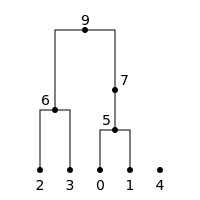


Tree on interval: (0.5, 1.0)


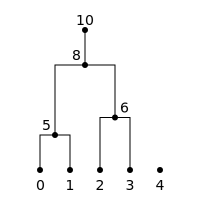

In [40]:
# Modify this code.
nodes_ex = io.StringIO("""\
id      is_sample   population      time
0       1       0               0.0
1       1       0               0.0
2       1       0               0.0
3       1       0               0.0
4       1       0               0.0
5       0       0               1.0
6       0       0               1.5
7       0       0               2.0
8       0       0               3.0
9       0       0               3.5
10      0       0               4.0
""")
edges_ex = io.StringIO("""\
id      left            right           parent  child
0       0.00000000      1.00000000      5       0
1       0.00000000      1.00000000      5       1
2       0.00000000      1.00000000      6       2
3       0.00000000      1.00000000      6       3
4       0.00000000      0.50000000      7       5
5       0.50000000      1.00000000      8       5
6       0.50000000      1.00000000      8       6
7       0.00000000      0.50000000      9       6
8       0.00000000      0.50000000      9       7
9       0.50000000      1.00000000      10      8
""")

# Load the tree sequence.
ts_ex = tskit.load_text(nodes=nodes_ex, edges=edges_ex, strict=False)

# Test by plotting it.
for tree in ts_ex.trees():
    print('Tree on interval:', tree.interval)
    display(SVG(tree.draw()))
    print()

We are now ready move on to simulating recombination.

Up to this point we have focused on simulations that returned a single tree representing the genealogy of a sample. The inclusion of recombination, however, means that there may be more than one tree relating our samples. The TreeSequence object returned by msprime is a very concise and efficient representation of these highly correlated trees. To process the trees, we simply consider them one at a time, using the trees( ) iterator.

To simulate with a constant recombination rate, we specify two extra inputs to simulate: a sequence length (most easily specified as a number of bases) and a recombination_rate (specified as the rate of crossovers per unit of length per generation).

Tree on interval (0.0, 181.74732201307717)


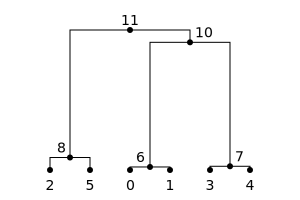

Tree on interval (181.74732201307717, 1000.0)


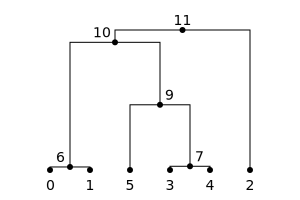

In [42]:
ts = msprime.simulate(sample_size = 6, random_seed = 12, length = 1000, 
                      recombination_rate = 1e-4 )

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

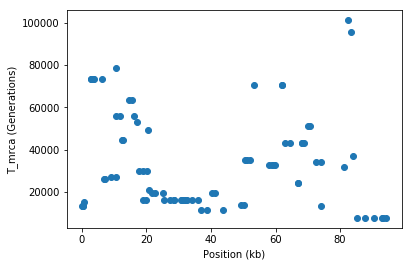

In [73]:
tmrca = np.zeros(ts.num_trees)
breakpoints = np.zeros(ts.num_trees)
for tree in ts.trees():
    tmrca[tree.index] = tree.time(tree.root)  
    breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o");
plt.show()

It's also possible to simulate under a variable rate of recombination. To do this, we can specify an external recombination map given as a RecombinationMap object. See the msprime documentation for more information about these objects.

In [69]:
ts = msprime.simulate(10, Ne=1e4, length=1e5, recombination_rate=1e-8, random_seed=3)
ts.num_trees

82

Positions on the map  [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Recombination rates  [0, 0.0001, 0.0005, 0.0001, 0, 0, 0, 0.0005, 0.0006, 0.0001, 0]
Tree on interval (0.0, 249.06398236496932)


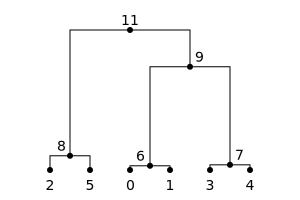

Tree on interval (249.06398236496932, 849.2285334503345)


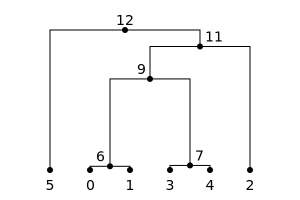

Tree on interval (849.2285334503345, 1000.0)


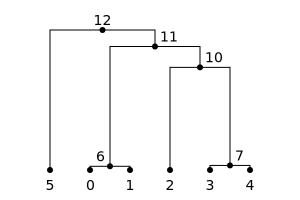

In [60]:
# Making a simple RecombinationMap object.
map_positions = [i*100 for i in range(0, 11)]
map_rates = [0, 1e-4, 5e-4, 1e-4, 0, 0, 0, 5e-4, 6e-4, 1e-4, 0]
my_map = msprime.RecombinationMap(map_positions, map_rates)
print("Positions on the map ",map_positions)
print("Recombination rates ", map_rates)

# Simulating with the recombination map.
ts = msprime.simulate(sample_size = 6, random_seed = 12, recombination_map = my_map)

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

In [44]:
# Read in the recombination map and run the simulation.
#infile = "genetic_map_GRCh37_chr22.txt"
#recomb_map = msprime.RecombinationMap.read_hapmap(infile)
#ts = msprime.simulate(
#    sample_size=100,
#    Ne=10**4,
#    recombination_map=recomb_map,
#    random_seed=1)

In [45]:
recomb_map = msprime.RecombinationMap.uniform_map(length=10, rate=1, num_loci=10)
ts = msprime.simulate(2, recombination_map=recomb_map)
list(ts.breakpoints())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0]

In [53]:
# Now plot the density of breakpoints along the chromosome
#breakpoints = np.array(list(ts.breakpoints()))
# Now we get the positions and rates from the recombination
# map and plot these using 500 bins.
#positions = np.array(recomb_map.get_positions()[1:])
#rates = np.array(recomb_map.get_rates()[1:])
#num_bins = 500
#v, bin_edges, _ = scipy.stats.binned_statistic(
#    positions, rates, bins=num_bins)
#x = bin_edges[:-1][np.logical_not(np.isnan(v))]
#y = v[np.logical_not(np.isnan(v))]
#fig, ax1 = plt.subplots()
#ax1.plot(x, y, color="blue")
#ax1.set_ylabel("Recombination rate")
#ax1.set_xlabel("Chromosome position")
#ax2 = ax1.twinx()
#v, bin_edges = np.histogram(breakpoints, num_bins, density=True)
#ax2.plot(bin_edges[:-1], v, color="green")
#ax2.set_ylabel("Breakpoint density")
#ax2.set_xlim(1.5e7, 5.3e7);
#plt.show()

# Demographic modelling in msprime

The most fundamental population parameter is the effective population size, or Ne. This parameter simply rescales time; larger effective population sizes correspond to older coalescence times:

In [47]:
def pairwise_T_mrca(Ne):
    N = 10000
    T_mrca = np.zeros(N)
    for j, ts in enumerate(msprime.simulate(2, Ne=Ne, num_replicates=N)):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.5), pairwise_T_mrca(10), pairwise_T_mrca(100)

(1.0017099002913024, 20.09586889853855, 201.3664205940196)

Thus, when we specify Ne = 10 we get a mean pairwise coalescence time of about 20 generations, and with Ne = 100, the mean coalescence time is about 200 generations.

When we provide an Ne parameter, this specifies a fixed effective population size. We can also model populations that are exponentially growing or contracting at some rate over time. 

In [75]:
def pairwise_T_mrca(growth_rate): #defining function to calculate T with different growth rates
    N = 10000
    T_mrca = np.zeros(N)    
    replicates = msprime.simulate(
        population_configurations=[
             msprime.PopulationConfiguration(
                sample_size=2, initial_size=0.5, growth_rate=growth_rate)], 
        num_replicates=N, random_seed=100)
    for j, ts in enumerate(replicates):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.05), pairwise_T_mrca(0), pairwise_T_mrca(-0.05)

(0.9342695408215712, 0.977927540084271, 1.0311575984750108)

msprime supports a discrete-deme model of population structure in which d panmictic populations exchange migrants according to the rates defined in an d × d matrix. This approach is very flexible, allowing us to simulate island models (in which all populations exchange migrants at a fixed rate), one- and two-dimensional stepping stone models (where migrants only move to adjacent demes) and other more complex migration patterns. 

Population structure is declared in msprime via the population_configurations and migration_matrix parameters in the simulate function.

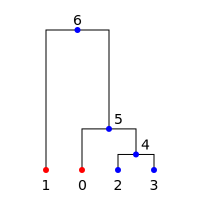

In [76]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=2),
    msprime.PopulationConfiguration(sample_size=2)
]
M = np.array([
    [0, 0.1],
    [0, 0]
])
ts  = msprime.simulate(
    population_configurations=pop_configs, migration_matrix=M,
    random_seed=2)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

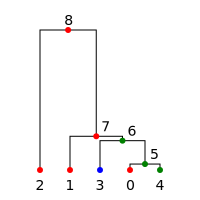

In [77]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=3),
    msprime.PopulationConfiguration(sample_size=1),
    msprime.PopulationConfiguration(sample_size=1)]
M = [
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]]
ts  = msprime.simulate(
    population_configurations=pop_configs, migration_matrix=M, record_migrations=True,
    random_seed=101)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

Let's try more complex scenario and run a simple simulation of a 5 population system, with a sample size of 20,000 in each population and human-like parameters.
The demography consists of a each of the five isolated populations merging into the single ancestral population after 5000, 10000, etc generations. This is a toy model and not intended to represent a realistic evolutionary scenario!

In [50]:
%%time
num_populations = 5 # Number of populations
n = 20000  # Per population sample size.
population_configs = [
    msprime.PopulationConfiguration(sample_size=n) 
    for _ in range(num_populations)
]
ts = msprime.simulate(
    Ne=10**4, mutation_rate=1e-8, recombination_rate=1e-8,
    length=1e7,  # 10 Mb
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=n) 
        for _ in range(num_populations)
    ],
    migration_matrix=np.zeros((num_populations, num_populations)),
    demographic_events=[
        msprime.MassMigration(5000, source=1, dest=0, proportion=1),
        msprime.MassMigration(10000, source=2, dest=0, proportion=1),
        msprime.MassMigration(15000, source=3, dest=0, proportion=1),
        msprime.MassMigration(20000, source=4, dest=0, proportion=1),
    ]
)
print("num trees = ", ts.num_trees, "num sites = ", ts.num_sites)

num trees =  184587 num sites =  190514
CPU times: user 17.6 s, sys: 163 ms, total: 17.8 s
Wall time: 17.8 s


We can now use this dataset to compute some of the statistics ith tskit library.

Tskit version 0.1.6 adds very powerful methods for computing population genetic statistics. We use the underlying trees and efficient algorithms to compute a wide range of population genetic statistics.

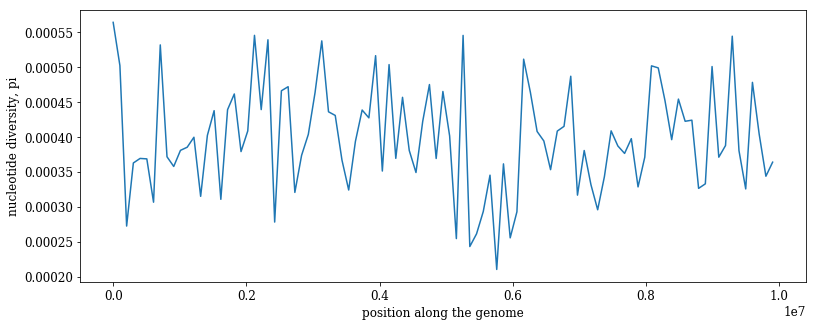

CPU times: user 623 ms, sys: 56.5 ms, total: 679 ms
Wall time: 484 ms


In [62]:
%%time
num_windows = 100
windows=np.linspace(0, ts.sequence_length, num=num_windows)

ml.rcParams['figure.figsize'] = (13.0, 5.0)
pop0_div = ts.diversity([ts.samples(0)], windows=windows)
plt.plot(windows[:-1], pop0_div)
plt.xlabel("position along the genome")
plt.ylabel("nucleotide diversity, pi")
plt.figaspect(1/10)
plt.show()

CPU times: user 384 ms, sys: 54.1 ms, total: 438 ms
Wall time: 436 ms


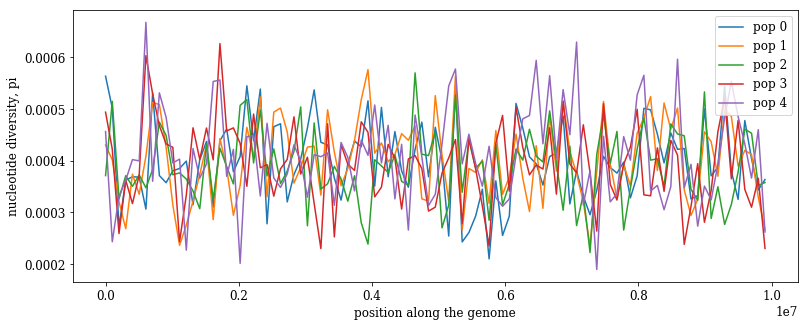

In [64]:
%%time
pop_samples = [ts.samples(j) for j in range(ts.num_populations)]
div = ts.diversity(pop_samples, windows=windows)
lines = plt.plot(windows[:-1], div)
plt.legend(lines, [f"pop {j}" for j in range(ts.num_populations)]);
plt.xlabel("position along the genome")
plt.ylabel("nucleotide diversity, pi")